# Image Classification (Fashion-MNIST)

Despite its popularity, MNist is considered a simple dataset, on which even a simple algorithm achieve classification accuracy over 95%. Fashion-MNIST was created to identify this issue in 2017. More about Fashion-MNIST could be 

In [1]:
%matplotlib inline
import d2l
import sys
from mxnet import gluon

mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [2]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

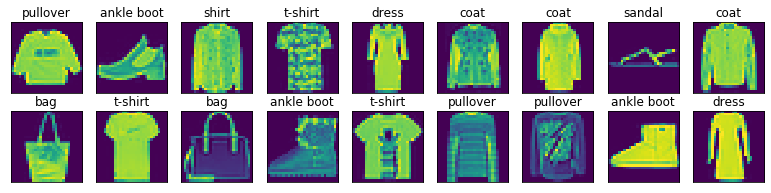

In [3]:
X, y = mnist_train[:18]
d2l.show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

We convert the image data from uint8 to 32-bit floating point number using the ToTensor class. Beyond that, it will divide all numbers by 255 so that all pixels have values between 0 and 1. The ToTensor class also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations

In [4]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True, num_workers=4)
timer = d2l.Timer()
for X, y in train_iter:
    continue
'Data could be loaded in totally %.2f sec' % timer.stop()

'Data could be loaded in totally 1.43 sec'

# Implementation of Softmax from Scratch

Softmax regression is the fundamental algorithm and we should know how to implement it from scratch. This section demos how to implement this algorithm using only **autograd**, **nd** and **gluon** from mxnet library.

In [5]:
%matplotlib inline
import d2l
from mxnet import nd, gluon, autograd
from IPython import display

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) # Load with original image size

num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

W.attach_grad()
b.attach_grad()

## The Softmax Function

Given a matrix X, we could sum all elements in X by X.sum(), or sum all elements in the same column by X.sum(axis=0), or sum all elements in the same row by X.sum(axis=1). Without setting *keepdims* to True, we receive a row / column vector with shape (dim,) or (,dim). This does not allow numpy to broadcast further the computation. 

For example:

In [6]:
ta = nd.array([[1,2],[3,4]])
ta.sum(), ta.sum(axis=0), ta.sum(axis=1)

(
 [10.]
 <NDArray 1 @cpu(0)>, 
 [4. 6.]
 <NDArray 2 @cpu(0)>, 
 [3. 7.]
 <NDArray 2 @cpu(0)>)

In [7]:
ta.sum(axis=0).shape

(2,)

In [8]:
ta / ta.sum(axis=1)


[[0.33333334 0.2857143 ]
 [1.         0.5714286 ]]
<NDArray 2x2 @cpu(0)>

### Softmax formula

$$ \text{softmax}(X)_{ij} = \frac{\text{exp}\big(X_{ij}\big)}{\sum_k \text{exp}\big(X_{ik}\big)} $$

The above formula calculates the probability of data i falling into the class j. X therefore will be a matrix with number of rows equals to the training batch size, and number of columns equals to the number of class. The implement of softmax will be as follow

In [9]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

## The model

For each training data with model trained W, we calculate the predicted probability that this data will belong to the class defined by train data. As in other neural network implementation, we flatten the whole  array of image to a long array.

We calculate the loss by negating the log likelihood 

$$ l = - \text{log}p(y|x) = - \sum_j y_j \text{log}\hat{y}_j $$

Where $\hat{y} = \text{softmax}(o)$. The softmax function maps o to a vector of probabilities for various outcomes.

In [10]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

The label will be an array with element of each element be the class that the corresponding data belong to. We could loop through the whole matrix and get the probability at y[i] as the corresponding train data but mxnet has **pick** function to perform the same action.

In [11]:
tyhat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.5, 0.2]])
ty = nd.array([2, 0])
nd.pick(tyhat, ty) # -> Should return [0.1, 0.2] as tyhat[0][0], tyhat[1][2]


[0.6 0.3]
<NDArray 2 @cpu(0)>

In [12]:
tyhat.argmax(axis=1)


[2. 1.]
<NDArray 2 @cpu(0)>

In [13]:
def cross_entropy(y_hat, y):
    return - nd.pick(y_hat, y).log()

## Training Accuracy

Training Accuracy should be the difference between the predicted class and the exact label. we evaluate accuracy by looping through each small batch, count the number of right classification and average the result per over batch size

In [14]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).sum().asscalar()

def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2) # num_corrected_examples, num_examples
    for X, y in data_iter:
        y = y.astype('float32')
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

For the example above, because we got one class right, the accuracy should be 1 and the evaluate accuracy should be 0.5

In [15]:
accuracy(tyhat, ty) / len(ty)

0.5

In [16]:
class Accumulator(object):
    """Sum a list of numbers over time"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a+b for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]


class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)    

## Model Training

None of the model can be solved analytically, so we oftenly use [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to hopefully find the global minima. At each step, using one batch randomly drawn from our dataset, we'll estimate the gradient of the loss with respect to our parameters. Then, we'll update our parameters a small in the direction that reduces the loss. Assuming that the gradient has already been calculated, each parameter (param) already has its gradient stored in param.grad. The following code applies the SGD update, given a set of parameters, a learning rate, and a batch size.

In [17]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [18]:
def train_epoch_ch3(net, train_iter, loss, updater):
    metric = Accumulator(3)
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        with autograd.record():
            yhat = net(X)
            l = loss(yhat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(l.sum().asscalar(), accuracy(yhat, y), y.size)
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    trains, test_accs = [], []
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

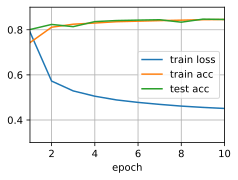

In [19]:
num_epochs, lr = 10, 0.1
updater = lambda batch_size: sgd([W,b], lr, batch_size)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

We train our model in 10 rounds an it seems that our train / test accuracy conversed. We are ready to classify some images. Given a series of images, we will compare their actual labels (first line of text ouput) and the model prediction (second line of text output).`

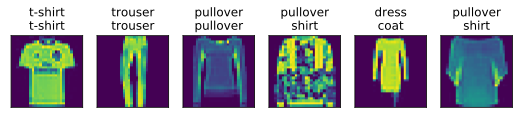

In [20]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y.asnumpy())
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
    titles = [true+'\n'+ pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# Implement Softmax classification using mxnet

The setup and intialization steps should be similar as in linear regression implementation. We will create an instance of a new Sequential class, and initialize it with 10 outputs because we have 10 outputs here. We also initialize our parameters using Normal distribution.

In [21]:
import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

## The Softmax

Recall our softmax function is 

$$ \text{softmax}(X)_{ij} = \frac{\text{exp}\big(X_{ij}\big)}{\sum_k \text{exp}\big(X_{ik}\big)} $$

While computing the probability, $z_j$ might become very large which make $e^{z_j}$ overflow the largest number float type could store. In those case, python returns *inf* and we might get improper probability number (0, inf). If we substracts all linear value to the max value before put it into softmax, in some cases, we likely get a number likely close to 0 or -inf. A few steps down the road of back-propagation, we start to get horific not-a-number (nan) results. 

We solve the overflow/underflow issue by using [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp), and gluon implemented that smart techniques for us in gluon.loss.SoftmaxCrossEntropyLoss() function.

In [22]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimization Algorithm
We are going to update our parameters using the same algorithm as Linear Regression. The function call therefore has the same form

In [23]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Training

We are going to use the same training procedure defined in the last section

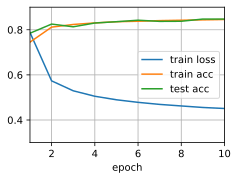

In [24]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)